In [1]:
from drl4dypm.agent import *
from drl4dypm.env import *
import time, copy

from matplotlib import pyplot as plt

# Params

In [2]:
# environment params
trading_days = 252
asset_names = ['AAL','CVS','FDX','F','AIG','CAT']
k = 10
cost_bps = 1e-3
path_to_data = 'data/stock_price_1D.csv'

# agent params
num_assets = len(asset_names)
state_dim = 3*(1+num_assets)
action_dim = 1+num_assets

critic_learning_rate = 1e-3
actor_learning_rate = critic_learning_rate * 0.5


# training params
max_episode = 200
min_episode_to_update = 10

In [3]:
network_params = {
    'actor': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5,
    },
    'critic': {
        'lstm': {
            'hidden_dim': 20,
            'num_layers': 1
        },
        'fc': [256,128,64,32],
        'dropout': 0.5,
    }
}


# IPM params
ipm_params = {
    'input_dim': 3*num_assets,
    'learning_rate': 0.1**3,
    'rnn_dim': 20,
    'delay': 3,
    'decay_rates': [0.1,0.2,0.5,0.8],
    'spectral_radius': 0.95,
    'sparsity': 0.5,
    'noise_mean': 0.,
    'noise_std': 0.01,
    'filter_window_length': 5,
    'filter_polyorder': 3
}


# BCM params
bcm_params = {
    'cost_bps': cost_bps,
    'update_rate': 0.1
}

# Agents and environment

In [4]:
env = TradingEnvironment(num_steps=trading_days, 
                         asset_names=asset_names, 
                         k=k, 
                         cost_bps=cost_bps,
                         agent_names=['base','ipm','bcm','full','crp'],
                         path_to_data=path_to_data
                        )

In [5]:
agent_base = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate
               )

agent_ipm = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate,
                ipm_params=ipm_params
               )

agent_bcm = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate,
                bcm_params=bcm_params
               )

agent_full = RLAgent(state_dim,
                action_dim,
                k,
                network_params,
                actor_learning_rate,
                critic_learning_rate,
                ipm_params=ipm_params,
                bcm_params=bcm_params
               )

agent_crp = CRPAgent(action_dim)

[2021-03-10 21:25:02,323] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.
[2021-03-10 21:25:02,331] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.
[2021-03-10 21:25:02,336] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.
[2021-03-10 21:25:02,343] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.


# Learning

In [ ]:
env.reset()

reward_base = []
reward_ipm = []
reward_bcm = []
reward_full = []
reward_crp = []

reward_sm_base = 0
reward_sm_ipm = 0
reward_sm_bcm = 0
reward_sm_full = 0
reward_sm_crp = 0

elp_sum = 0
start_time = time.time()


cols = ['r_base','r_ipm','r_bcm','r_full','r_crp',
        'elp','elp_sum']
line = 'episode |' + '|'.join([f'{col:<10}' for col in cols])
print(line)



for e in range(max_episode):
    state, end = env.init_step()
    last_actions = env.simulator.last_actions
    
    # get IPM prediction
    ipm_predict_ipm = agent_ipm.ipm_predict_and_learn(state[-1])
    ipm_predict_full = agent_full.ipm_predict_and_learn(state[-1])
    
    while not end:
        with torch.no_grad():
            # generate action
            action_base = agent_base.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                            last_action=torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1))
            
            action_ipm = agent_ipm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                        last_action=torch.tensor(last_actions['ipm'], dtype=torch.float32).view(1,-1),
                                        ipm_predict=torch.tensor(ipm_predict_ipm, dtype=torch.float32).view(1,-1))
            
            action_bcm = agent_bcm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                            last_action=torch.tensor(last_actions['bcm'], dtype=torch.float32).view(1,-1))
            
            
            action_full = agent_full.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                        last_action=torch.tensor(last_actions['full'], dtype=torch.float32).view(1,-1),
                                        ipm_predict=torch.tensor(ipm_predict_full, dtype=torch.float32).view(1,-1))
            
            action_crp = agent_crp.get_action()
            
            
            # execute action and move to next step
            actions = {'base': action_base.numpy().reshape(-1),
                      'ipm': action_ipm.numpy().reshape(-1),
                       'bcm': action_bcm.numpy().reshape(-1),
                       'full': action_full.numpy().reshape(-1),
                       'crp': action_crp
                      }
            rewards, next_state, end = env.take_step(actions, state[0])
            
            # train IPM with next state and get next prediction
            next_ipm_predict_ipm = agent_ipm.ipm_predict_and_learn(state[-1], next_state[-1])
            next_ipm_predict_full = agent_full.ipm_predict_and_learn(state[-1], next_state[-1])
            
    
            # get CBM action
            bcm_action_bcm = agent_bcm.get_bcm_action(state[0], next_state[0])
            bcm_action_full = agent_full.get_bcm_action(state[0], next_state[0])
            
            
            
            # store experience
            agent_base.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['base'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                        'last_action': torch.tensor(actions['base'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['base'],
                'terminal': end
            })
            
            agent_ipm.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                          'last_action': torch.tensor(last_actions['ipm'], dtype=torch.float32).view(1,-1),
                         'ipm': torch.tensor(ipm_predict_ipm, dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['ipm'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                               'last_action': torch.tensor(actions['ipm'], dtype=torch.float32).view(1,-1),
                              'ipm': torch.tensor(next_ipm_predict_ipm, dtype=torch.float32).view(1,-1)},
                'reward': rewards['ipm'],
                'terminal': end
            })
            
            agent_bcm.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(last_actions['bcm'], dtype=torch.float32).view(1,-1)},
                'action': {'action': torch.tensor(actions['bcm'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(actions['bcm'], dtype=torch.float32).view(1,-1)},
                'reward': rewards['bcm'],
                'terminal': end,
                'bcm_action': torch.tensor(bcm_action_bcm)
            })
            
            
            agent_full.store_transition({
                'state': {'state': torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                         'last_action': torch.tensor(last_actions['full'], dtype=torch.float32).view(1,-1),
                         'ipm': torch.tensor(ipm_predict_full, dtype=torch.float32).view(1,-1)
                         },
                'action': {'action': torch.tensor(actions['full'], dtype=torch.float32).view(1,-1)},
                'next_state': {'state': torch.tensor(next_state[1], dtype=torch.float32).view(1,k,-1),
                               'last_action': torch.tensor(actions['full'], dtype=torch.float32).view(1,-1),
                               'ipm': torch.tensor(next_ipm_predict_full, dtype=torch.float32).view(1,-1)
                              },
                'reward': rewards['full'],
                'terminal': end,
                'bcm_action': torch.tensor(bcm_action_full)
            })
            
        
        
        state = next_state
        last_actions = actions
        ipm_predict_ipm = next_ipm_predict_ipm
        ipm_predict_full = next_ipm_predict_full
    
    
    # update agents
    if e > min_episode_to_update:
        for _ in range(trading_days):
            agent_base.update()
            agent_ipm.update()
            agent_bcm.update()
            agent_full.update()
    
    # compute smoothed reward
    rewards = env.get_total_rewards()
    
    reward_sm_base = reward_sm_base * 0.9 + rewards['base'] * 0.1
    reward_corr_base = reward_sm_base/(1-0.9**(e+1))
    
    reward_sm_ipm = reward_sm_ipm * 0.9 + rewards['ipm'] * 0.1
    reward_corr_ipm = reward_sm_ipm/(1-0.9**(e+1))
    
    reward_sm_bcm = reward_sm_bcm * 0.9 + rewards['bcm'] * 0.1
    reward_corr_bcm = reward_sm_bcm/(1-0.9**(e+1))
        
    reward_sm_full = reward_sm_full * 0.9 + rewards['full'] * 0.1
    reward_corr_full = reward_sm_full/(1-0.9**(e+1))
    
    reward_sm_crp = reward_sm_crp * 0.9 + rewards['crp'] * 0.1
    reward_corr_crp = reward_sm_crp/(1-0.9**(e+1))
        
    
    # save smoothed reward
    reward_base.append(reward_corr_base)
    reward_ipm.append(reward_corr_ipm)
    reward_bcm.append(reward_corr_bcm)
    reward_full.append(reward_corr_full)
    reward_crp.append(reward_corr_crp)
    
    
    if e%10 == 0:
        # print results per 10 iterations
        elp = time.time()-start_time
        elp_sum += elp
        start_time = time.time()
        
        line = f'{e:<8}|' + '|'.join([f'{col:<10.4f}' for col in [reward_corr_base, reward_corr_ipm,
                                                                  reward_corr_bcm, reward_corr_full,
                                                                  reward_corr_crp, elp, elp_sum]])
    
        print(line)
    
    
    # reset environment and IPM predictors
    env.reset()
    agent_ipm.ipm_init()
    agent_full.ipm_init()
    
    
    
    
    


[2021-03-10 21:25:46,481] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-10 21:25:46,494] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-10 21:25:46,496] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-10 21:25:46,498] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is 

episode |r_base    |r_ipm     |r_bcm     |r_full    |r_crp     |elp       |elp_sum   
0       |-0.0930   |-0.0488   |-0.0461   |-0.0694   |-0.0622   |16.2891   |16.2891   
10      |-0.0549   |-0.0401   |-0.0397   |-0.0473   |-0.0442   |160.2266  |176.5157  


[2021-03-10 21:28:58,499] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-10 21:28:58,522] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-10 21:28:58,539] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Critic'>, automatically determined and set to: cpu
The framework is not responsible for any un-matching device issues caused by this operation.
[2021-03-10 21:28:58,665] <WARNING>:default_logger:You have not specified the i/o device of your model <class 'drl4dypm.agent.Actor'>, automatically determined and set to: cpu
The framework i

20      |-0.0958   |-0.0712   |-0.0947   |-0.0983   |-0.0805   |701.4752  |877.9910  


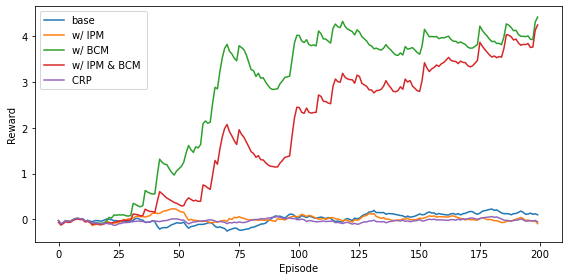

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(reward_base, label='base')
ax.plot(reward_ipm, label='w/ IPM ')
ax.plot(reward_bcm, label='w/ BCM ')
ax.plot(reward_full, label='w/ IPM & BCM ')
ax.plot(reward_crp, label='CRP ')


ax.set_ylabel('Reward')
ax.set_xlabel('Episode')
ax.legend()

fig.tight_layout()
fig.savefig('figs/cmp_all.png')

# Performance

## single episode

In [8]:
env.reset()

price_epi = []

action_epi_base = []
action_epi_bcm = []
action_epi_ipm = []
action_epi_full = []

reward_epi_base = []
reward_epi_bcm = []
reward_epi_ipm = []
reward_epi_full = []
reward_epi_crp = []


state, end = env.init_step()
last_actions = env.simulator.last_actions

# get IPM prediction
ipm_predict_ipm = agent_ipm.ipm_predict_and_learn(state[-1])
ipm_predict_full = agent_full.ipm_predict_and_learn(state[-1])
    
while not end:
    with torch.no_grad():
        # generate action
        action_base = agent_base.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                           last_action=torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1),
                                           with_noise=False)
            
        action_ipm = agent_ipm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                         last_action=torch.tensor(last_actions['ipm'], dtype=torch.float32).view(1,-1),
                                         ipm_predict=torch.tensor(ipm_predict_ipm, dtype=torch.float32).view(1,-1),
                                         with_noise=False)

        action_bcm = agent_bcm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                         last_action=torch.tensor(last_actions['bcm'], dtype=torch.float32).view(1,-1),
                                         with_noise=False)


        action_full = agent_full.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                            last_action=torch.tensor(last_actions['full'], dtype=torch.float32).view(1,-1),
                                            ipm_predict=torch.tensor(ipm_predict_full, dtype=torch.float32).view(1,-1),
                                            with_noise=False)

        action_crp = agent_crp.get_action()
        
        

        # execute action and move to next step
        actions = {'base': action_base.numpy().reshape(-1),
                  'ipm': action_ipm.numpy().reshape(-1),
                   'bcm': action_bcm.numpy().reshape(-1),
                   'full': action_full.numpy().reshape(-1),
                   'crp': action_crp
                  }
        rewards, next_state, end = env.take_step(actions, state[0])
        

    state = next_state
    last_actions = actions
    
    ipm_predict_ipm = next_ipm_predict_ipm
    ipm_predict_full = next_ipm_predict_full
    
    
    price_epi.append(state[0])
    
    action_epi_base.append(action_base.numpy().reshape(-1))
    action_epi_ipm.append(action_ipm.numpy().reshape(-1))
    action_epi_bcm.append(action_bcm.numpy().reshape(-1))
    action_epi_full.append(action_full.numpy().reshape(-1))
    
    reward_epi_base.append(rewards['base'])
    reward_epi_ipm.append(rewards['ipm'])
    reward_epi_bcm.append(rewards['bcm'])
    reward_epi_full.append(rewards['full'])
    reward_epi_crp.append(rewards['crp'])

    
    




In [9]:
price_epi = np.array(price_epi)

action_epi_base = np.array(action_epi_base)
action_epi_ipm = np.array(action_epi_ipm)
action_epi_bcm = np.array(action_epi_bcm)
action_epi_full = np.array(action_epi_full)



reward_epi_base = np.array(reward_epi_base).cumsum()
reward_epi_ipm = np.array(reward_epi_ipm).cumsum()
reward_epi_bcm = np.array(reward_epi_bcm).cumsum()
reward_epi_full = np.array(reward_epi_full).cumsum()
reward_epi_crp = np.array(reward_epi_crp).cumsum()



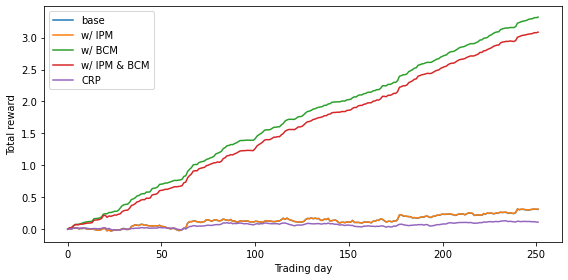

In [33]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
    

ax.plot(reward_epi_base, label='base')
ax.plot(reward_epi_ipm, label='w/ IPM')
ax.plot(reward_epi_bcm, label='w/ BCM')
ax.plot(reward_epi_full, label='w/ IPM & BCM')
ax.plot(reward_epi_crp, label='CRP')

ax.legend()

    
ax.set_xlabel('Trading day')
ax.set_ylabel('Total reward')

fig.tight_layout()
fig.savefig('figs/test_sing_epi_r.png')

Text(0, 0.5, 'Asset price')

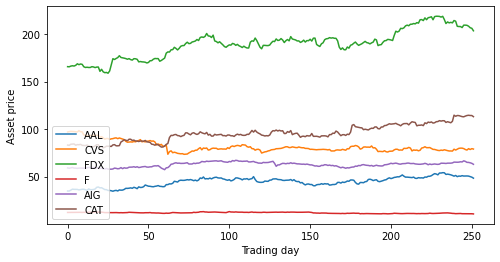

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
    

for i in range(len(asset_names)):
    ax.plot(price_epi[:,i+1], label=asset_names[i])
    
ax.legend(loc='lower left')

    
ax.set_xlabel('Trading day')
ax.set_ylabel('Asset price')

# fig.tight_layout()
# fig.savefig('figs/test_sing_epi_p.png')

Text(0, 0.5, 'Portfolio weight (w/ BCM)')

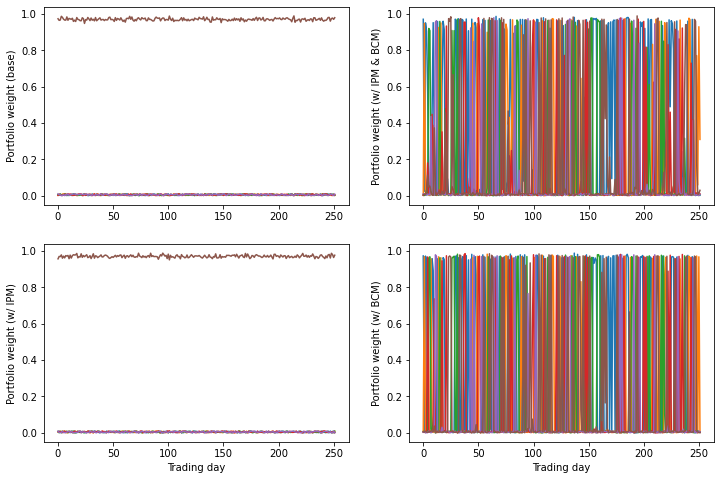

In [12]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
    


for i in range(len(asset_names)):
    axs[0,0].plot(action_epi_base[:,i+1], label=asset_names[i])
    axs[0,1].plot(action_epi_full[:,i+1], label=asset_names[i])
    axs[1,0].plot(action_epi_ipm[:,i+1], label=asset_names[i])
    axs[1,1].plot(action_epi_bcm[:,i+1], label=asset_names[i])

    
axs[1,0].set_xlabel('Trading day')
axs[1,1].set_xlabel('Trading day')

axs[0,0].set_ylabel('Portfolio weight (base)')
axs[0,1].set_ylabel('Portfolio weight (w/ IPM & BCM)')
axs[1,0].set_ylabel('Portfolio weight (w/ IPM)')
axs[1,1].set_ylabel('Portfolio weight (w/ BCM)')


# fig.tight_layout()
# fig.savefig('figs/test_sing_epi_a.png')

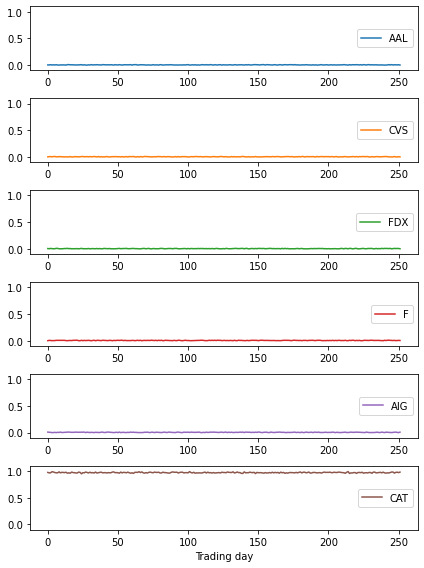

In [40]:
fig, axs = plt.subplots(len(asset_names),1, figsize=(6,8))
    

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for i in range(len(asset_names)):
    axs[i].plot(action_epi_base[:,i+1], label=asset_names[i], color=colors[i])
    axs[i].legend(loc='center right')
    axs[i].set_ylim([-0.1,1.1])

    
axs[-1].set_xlabel('Trading day')

fig.tight_layout()
fig.savefig('figs/test_sing_epi_a_base.png')

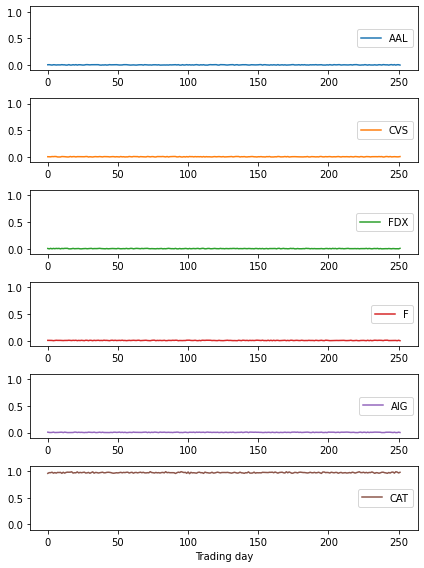

In [41]:
fig, axs = plt.subplots(len(asset_names),1, figsize=(6,8))
    

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for i in range(len(asset_names)):
    axs[i].plot(action_epi_ipm[:,i+1], label=asset_names[i], color=colors[i])
    axs[i].legend(loc='center right')
    axs[i].set_ylim([-0.1,1.1])

    
axs[-1].set_xlabel('Trading day')

fig.tight_layout()
fig.savefig('figs/test_sing_epi_a_ipm.png')

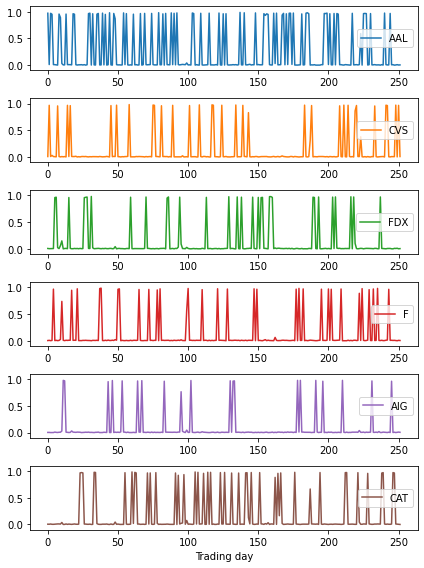

In [42]:
fig, axs = plt.subplots(len(asset_names),1, figsize=(6,8))
    

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for i in range(len(asset_names)):
    axs[i].plot(action_epi_bcm[:,i+1], label=asset_names[i], color=colors[i])
    axs[i].legend(loc='center right')
    axs[i].set_ylim([-0.1,1.1])

    
axs[-1].set_xlabel('Trading day')

fig.tight_layout()
fig.savefig('figs/test_sing_epi_a_bcm.png')

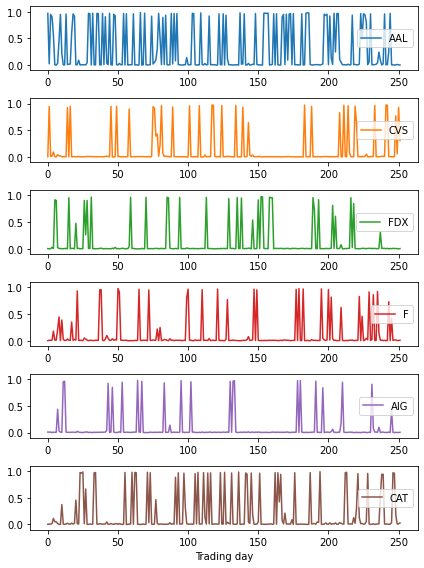

In [43]:
fig, axs = plt.subplots(len(asset_names),1, figsize=(6,8))
    

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for i in range(len(asset_names)):
    axs[i].plot(action_epi_full[:,i+1], label=asset_names[i], color=colors[i])
    axs[i].legend(loc='center right')
    axs[i].set_ylim([-0.1,1.1])

    
axs[-1].set_xlabel('Trading day')

fig.tight_layout()
fig.savefig('figs/test_sing_epi_a_full.png')

## multi episodes

In [13]:
def downside_std(df):
    mean_val = np.mean(df, axis=0)
    ds_std = []
    
    for name in df.columns:
        idx = df[name] < mean_val[name]
        ds_std.append(np.std(df.loc[idx,name]))
    
    return ds_std
        

In [14]:
test_episode = 100

In [60]:
env.reset()
gamma = .99

test_return_base = []
test_return_bcm = []
test_return_ipm = []
test_return_full = []
test_return_crp = []


for e in range(test_episode):  
    state, end = env.init_step()
    last_actions = env.simulator.last_actions
    
    disc_reward_base = 0
    disc_reward_bcm = 0
    disc_reward_ipm = 0
    disc_reward_full = 0
    disc_reward_crp = 0

    # get IPM prediction
    ipm_predict_ipm = agent_ipm.ipm_predict_and_learn(state[-1])
    ipm_predict_full = agent_full.ipm_predict_and_learn(state[-1])

    step = 0
    while not end:
        with torch.no_grad():
            # generate action
            action_base = agent_base.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                                last_action=torch.tensor(last_actions['base'], dtype=torch.float32).view(1,-1),
                                               with_noise=False)

            action_ipm = agent_ipm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                             last_action=torch.tensor(last_actions['ipm'], dtype=torch.float32).view(1,-1),
                                             ipm_predict=torch.tensor(ipm_predict_ipm, dtype=torch.float32).view(1,-1),
                                             with_noise=False)

            action_bcm = agent_bcm.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                             last_action=torch.tensor(last_actions['bcm'], dtype=torch.float32).view(1,-1),
                                             with_noise=False)


            action_full = agent_full.get_action(torch.tensor(state[1], dtype=torch.float32).view(1,k,-1),
                                                last_action=torch.tensor(last_actions['full'], dtype=torch.float32).view(1,-1),
                                                ipm_predict=torch.tensor(ipm_predict_full, dtype=torch.float32).view(1,-1),
                                                with_noise=False)

            action_crp = agent_crp.get_action()



            # execute action and move to next step
            actions = {'base': action_base.numpy().reshape(-1),
                      'ipm': action_ipm.numpy().reshape(-1),
                       'bcm': action_bcm.numpy().reshape(-1),
                       'full': action_full.numpy().reshape(-1),
                       'crp': action_crp
                      }
            rewards, next_state, end = env.take_step(actions, state[0])


        state = next_state
        last_actions = actions

        ipm_predict_ipm = next_ipm_predict_ipm
        ipm_predict_full = next_ipm_predict_full
        
        disc_factor = gamma**step
        disc_reward_base += rewards['base']*disc_factor
        disc_reward_bcm += rewards['bcm']*disc_factor
        disc_reward_ipm += rewards['ipm']*disc_factor
        disc_reward_full += rewards['full']*disc_factor
        disc_reward_crp += rewards['crp']*disc_factor
        
        step += 1 


    # save rewards    
    test_return_base.append(np.exp(disc_reward_base)-1)
    test_return_ipm.append(np.exp(disc_reward_ipm)-1)
    test_return_bcm.append(np.exp(disc_reward_bcm)-1)
    test_return_full.append(np.exp(disc_reward_full)-1)
    test_return_crp.append(np.exp(disc_reward_crp)-1)
    
    
    # reset environment and IPM predictors
    env.reset()
    agent_ipm.ipm_init()
    agent_full.ipm_init()

    


In [61]:
df_return = pd.DataFrame(data = {
    'base': test_return_base,
    'ipm': test_return_ipm,
    'bcm': test_return_bcm,
    'full': test_return_full,
    'crp': test_return_crp
})

In [62]:
df_return[:10]

,base,ipm,bcm,full,crp
0,0.169126,0.169005,2.267589,2.115988,0.031882
1,-0.121092,-0.121113,2.989668,2.788340,-0.121888
2,0.034902,0.034875,4.246415,3.904314,-0.049003
3,0.207463,0.207332,2.963542,2.664727,0.042502
4,-0.087185,-0.087170,3.083869,2.830581,-0.063478
5,0.152559,0.152477,2.636998,2.115554,0.044744
6,-0.133180,-0.133171,3.072396,2.866935,-0.121183
7,-0.006030,-0.006109,3.567091,3.197478,-0.049927
8,-0.065564,-0.065606,11.161493,10.330412,-0.126128
9,-0.025009,-0.024985,3.472230,2.992845,0.002247


In [63]:
# metrics

ann_return = np.mean(df_return, axis = 0)
ann_volatility = np.std(df_return, axis = 0)
sharpe_ratio = np.mean(df_return, axis=0)/np.std(df_return, axis=0)
sortino_ratio = np.mean(df_return, axis=0)/downside_std(df_return)

stat = pd.DataFrame(data = {
    'ann_return': ann_return,
    'ann_volat': ann_volatility,
    'sharpe_ratio': sharpe_ratio,
    'sortino_ratio': sortino_ratio
})

stat

,ann_return,ann_volat,sharpe_ratio,sortino_ratio
base,0.042498,0.110721,0.383826,0.858039
ipm,0.042448,0.110688,0.383495,0.857260
bcm,5.017052,5.063715,0.990785,8.300755
full,4.653823,4.896461,0.950446,8.771673
crp,-0.025192,0.066695,-0.377725,-0.687848


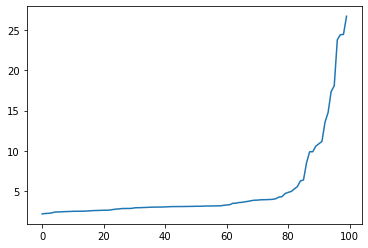

In [64]:
plt.plot(np.sort(df_return.bcm))